<a href="https://colab.research.google.com/github/Akovognon2003/Arduino_JSON/blob/master/Text-to-text-csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in **Colab**

Il s'agit d'un script simplifié permettant d'affiner GPT2 en utilisant la bibliothèque Transformers de Hugging Face et PyTorch.

Vous devez comprendre les bases de PyTorch et le fonctionnement d'une boucle d'entraînement avant de commencer. La connaissance du fonctionnement de GPT2 peut être utile mais n'est pas nécessaire. Le code a été écrit dans un souci de clarté et non de réutilisation. Je conseille de le remanier pour des projets réels. J'ai généreusement repris des éléments du tutoriel de Chris McCormick sur le réglage fin du BERT, du tutoriel de Ian Porter sur le GPT2 et du script de réglage fin du modèle Hugging Face Language, donc tout le mérite leur revient. Le code de Chris a pratiquement fourni la base de ce script - vous devriez absolument consulter son blog.

Je dois mentionner ce que le script ne couvre pas :

  - L'utilisation de la bibliothèque nlp pour charger l'ensemble de données et mettre en place le flux de travail d'entraînement, qui semble rationaliser les choses de manière assez agréable.
  - Accumulation de gradients - cela permet d'obtenir des tailles de lots effectives plus importantes que celles autorisées par Colab (GPT2 est un modèle de grande taille, et toute taille de lot supérieure à 2 suffirait à provoquer une erreur CUDA de mémoire insuffisante sur Colab).
  - Gel des couches. Il s'agit du processus consistant à ne modifier que les paramètres des couches sélectionnées, rendu célèbre par le processus ULMFit.
  - Utilisation de "past" lors de la génération de texte. Cela permet de prendre en compte l'état précédent lors de la génération d'éléments de texte successifs. Je n'en ai pas eu besoin.
  - Emballage des tenseurs. Il s'agit d'un moyen efficace d'intégrer un maximum de données d'entraînement dans chaque lot.
  - Recherche d'hyperparamètres. J'ai rapidement choisi des valeurs qui semblaient produire des valeurs correctes, sans vérifier si elles étaient optimales.

Nous avons réutilisé ainsi ce tutoriel dans le cadre de la formation sur l'EEIA 2023. Ainsi, nous ne partons pas de zéro et orientons mieux les participants sur le fine turning d'un modele Text to Text avec GPT2.
Vous pouvez revoir le code complet à cet adresse https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=EKOTlwcmxmej .

#### Il est important de souligner que ce travail se base sur un travail initiale où nous avons adapté le modele gpt2 aux données du covid19

__author__ = "NOBIME Tanguy Adonis"

__copyright__ = "Copyright 2023, EEIA 2023"

__credits__ = ["Vincent Whannou de Dravo, Vivien Ogoun, Adonis Nobime, Landry Bossou and Konig Koudogbo"]

__license__ = "MIT"

__version__ = "1.0.0"

__maintainer__ = "Vivien Ogoun, and Vincent Whannou de Dravo and Adonis Nobime and Landry Bossou and Konig Koudogbo"

__email__ = "nobimetanguy19@gmail.com"

__status__ = "Dev"



Installation du package transformers avec cette commande :
!pip install transformers

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00


Importation des packages nécessaires

In [3]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Création d'un ensemble d'entraînement

Les données utilisées pour affiner le modèle linguistique sont un ensemble d'environ 1000 ensemble de données COVID sur la détection des fausses nouvelles, dans le but de les générer dans le même format général et le même style.

In [4]:
path = "/content/drive/MyDrive/covid_faq.csv"

In [5]:
# lecture des données
df = pd.read_csv(path)
df.head()

,questions,answers
0,What is a novel coronavirus?,A novel coronavirus is a new coronavirus that ...
1,Why is the disease being called coronavirus di...,"On February 11, 2020 the World Health Organiza..."
2,How does the virus spread?,The virus that causes COVID-19 is thought to s...
3,Can I get COVID-19 from food (including restau...,Currently there is no evidence that people can...
4,Will warm weather stop the outbreak of COVID-19?,It is not yet known whether weather and temper...


In [6]:
# Analyse des données manquantes
df.isnull().sum()

questions    0
answers      0
dtype: int64

In [7]:
# Prise des réponses sur la covid
answers_covid = df.answers.copy()

Nous devons nous faire une idée de la longueur de nos documents d'apprentissage.

Je ne vais pas utiliser le même tokenizer que celui de GPT2, qui est un tokenizer de codage par paire d'octets. Au lieu de cela, j'en utilise un simple, juste pour avoir une idée approximative.

<ipython-input-8-889de062fe13>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

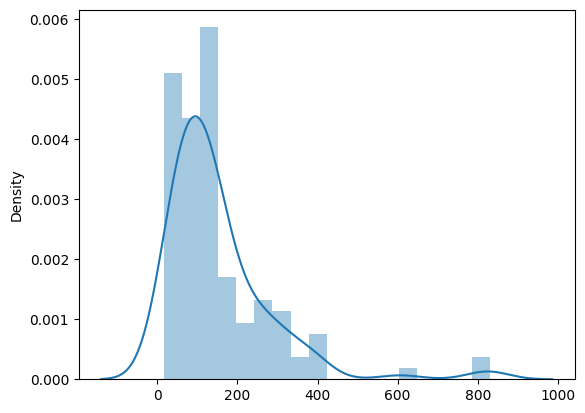

In [8]:
doc_lengths = []

for bio in answers_covid :

    # obtenir une distribution approximative du nombre de jetons
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
help

In [ ]:
# la longueur moyenne d'un jeton
np.average(doc_lengths)

# GPT2 Tokenizer
Bien que les valeurs par défaut s'en chargent, j'ai pensé montrer qu'il est possible de spécifier certains des jetons spéciaux.

In [ ]:
# Lecture de Tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

# Ensembles de données et chargeurs de données PyTorch
GPT2 est un modèle de grande taille. L'augmentation de la taille des lots au-delà de 2 a conduit à des problèmes de mémoire insuffisante. Ce problème peut être atténué en accumulant les gradients, mais cela n'entre pas dans le cadre de cette étude.

In [ ]:
batch_size = 2

J'utilise l'approche standard de PyTorch pour charger les données en utilisant une classe dataset.

Je passe le tokenizer en argument mais normalement je devrais l'instancier dans la classe.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

Pour comprendre comment j'ai utilisé le tokenizer, il est utile de lire la documentation. J'ai enveloppé chaque bio dans les jetons bos et eos.

Chaque tenseur transmis au modèle doit avoir la même longueur.

Si la bio est plus courte que 768 tokens, elle sera ramenée à une longueur de 768 en utilisant le token padding. De plus, un masque d'attention sera renvoyé et devra être transmis au modèle pour lui indiquer d'ignorer les jetons de remplissage.

Si la bio est plus longue que 768 tokens, elle sera tronquée sans le eos_token. Ce n'est pas un problème.

In [ ]:
dataset = GPT2Dataset(answers_covid, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
# Créer les DataLoaders pour nos ensembles de données d'entraînement et de validation.
# Nous allons prendre des échantillons d'entraînement dans un ordre aléatoire.
train_dataloader = DataLoader(
            train_dataset,  # Les échantillons de formation.
            sampler = RandomSampler(train_dataset), # Sélectionner les lots de manière aléatoir
            batch_size = batch_size # Trains avec cette taille de lot.
        )

# Pour la validation, l'ordre n'a pas d'importance, nous les lirons donc de manière séquentielle.
validation_dataloader = DataLoader(
            val_dataset, # Les échantillons de validation.
            sampler = SequentialSampler(val_dataset), # Retirer les lots de manière séquentielle.
            batch_size = batch_size # Évaluer avec cette taille de lot.
)

# Finetune GPT2 Language Model

In [ ]:
# Je ne fais rien avec la configuration buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instanciation du modèle
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# cette étape est nécessaire car j'ai ajouté des tokens (bos_token, etc) aux embeddings
# sinon les tenseurs du tokenizer et du modèle ne correspondront pas
model.resize_token_embeddings(len(tokenizer))

# Indiquer à pytorch d'exécuter ce modèle sur le GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# Quelques paramètres que j'ai élaborés et qui fonctionnent raisonnablement bien

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# ceci produit un échantillon de sortie tous les 100 pas
sample_every = 100

In [ ]:
# Note : AdamW est une classe de la bibliothèque huggingface (par opposition à pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Le nombre total d'étapes d'apprentissage est [nombre de lots] x [nombre d'époques].
# (Notez que ce n'est pas la même chose que le nombre d'échantillons d'apprentissage).
total_steps = len(train_dataloader) * epochs

# Créer le planificateur du taux d'apprentissage.
# Il modifie le taux d'apprentissage au fur et à mesure de la progression de la boucle d'apprentissage.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Voyons le résumé du processus de formation.

In [ ]:
# Afficher les flottants avec deux décimales.
pd.set_option('display.precision', 2)

# Créer un DataFrame à partir de nos statistiques d'entraînement.
df_stats = pd.DataFrame(data=training_stats)

# Utiliser 'epoch' comme index de ligne.
df_stats = df_stats.set_index('epoch')

# Un hack pour forcer les en-têtes de colonnes à s'enrouler.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Affiche le tableau.
df_stats

In [ ]:
# Utiliser le style d'intrigue de seaborn.
sns.set(style='darkgrid')

# Augmenter la taille du tracé et la taille de la police.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Tracer la courbe d'apprentissage.
plt.plot(df_stats['Training Loss'], 'b-o', label="Entrainement")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Etiqueter le graphique.
plt.title("Entrainement et Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Afficher les informations sur le modèle

In [ ]:
# Obtenir tous les paramètres du modèle sous la forme d'une liste de tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Sauvegarde et chargement d'un modèle affiné

In [ ]:
# Sauvegarde des meilleures pratiques : si vous utilisez des noms par défaut pour le modèle, vous pouvez le recharger en utilisant from_pretrained().

output_dir = './model_save/'

# Créer un répertoire de sortie si nécessaire
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Sauvegarder un modèle entraîné, une configuration et un tokenizer en utilisant `save_pretrained()`.
# Ils peuvent ensuite être rechargés en utilisant `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Prendre en charge la formation distribuée/parallèle
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Bonne pratique : sauvegarder les arguments d'entraînement avec le modèle entraîné
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

In [ ]:
!ls -l --block-size=K ./model_save/

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

In [ ]:
# Copiez les fichiers du modèle dans un répertoire de votre Google Drive.
!cp -r ./model_save/ $data_dir

# # Charger un modèle entraîné et un vocabulaire que vous avez affiné
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generation de texte

In [ ]:
model.eval()

prompt = "covid19 symptoms"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))